In [1]:
import pandas as pd
import numpy as np
from gurobipy import GRB
import gurobipy as gp
from statistics import mean 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme()
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn import linear_model

import warnings
warnings.simplefilter("ignore")

In [2]:
grb_runtime = 100

## Reading the data

In [3]:
train_data = pd.read_csv('training_data.csv')
test_data = pd.read_csv('test_data.csv')

#training df
train_df = train_data.copy()

#test df
test_df =test_data.copy()

# Storing raw training IVs and DV before prepocessing step 
X_train_og, y_train_og = train_data.drop(columns='y').to_numpy(), train_data['y'].to_numpy()

train_df.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [4]:
test_df.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


## Data Shuffling and Data Split

In [5]:
# shuffling
shuffled_ind = np.random.choice(train_df.index, size=len(train_df), replace=False)
shuffled_train_df = train_df.iloc[shuffled_ind]
X_train, y_train = shuffled_train_df.drop(columns='y').to_numpy(), shuffled_train_df['y'].to_numpy()

#splitting test df
X_test, y_test = test_df.drop(columns='y').to_numpy(), test_df['y'].to_numpy()

In [6]:
num_k_folds = 10

#splitting training df into 10 folds for cross-validation
split_ind = KFold(n_splits=num_k_folds).split(X_train)

k_folds_dict = {}
for i, ind in enumerate(split_ind):
    #temp dictionary 
    index_dict = {}
    # The training indices are in the first item of the tuple and the testing indices are in the second.
    index_dict['train_indices'] = ind[0]
    index_dict['test_indices'] = ind[1]
    k_folds_dict[i] = index_dict

In [7]:
#list of k values to try
k_options = np.arange(5,51,5)

#initializing dataframe to store cross validation results
grb_df = pd.DataFrame(index=k_folds_dict.keys(),columns=k_options)

## Building the MIQP Model

In [8]:
def predictions(x,betas):
    pred = []

    for i in range(x.shape[0]):
        pred_val = betas[0]
        for j in range(x.shape[1]):
            pred_val+= x[i,j]*betas[j+1]
            
        pred.append(pred_val)
    return pred

def sse(y,pred):
     return sum((y - pred)**2)

In [9]:
# Nested loops for k values and cross-validation folds
if os.path.exists('results.csv'):
    grb_df = pd.read_csv('results.csv')
else:
    for k in k_options:
        print(f"for k = {k}")
        for fold, indices_dict in k_folds_dict.items():
            # Select data for the current fold
            X_fold, y_fold = X_train[indices_dict['train_indices']], y_train[indices_dict['train_indices']]

            # Create a Gurobi model
            model = gp.Model()

            # variables
            beta = model.addMVar(X_train.shape[1] + 1, name="beta", lb=-np.inf)
            z = model.addMVar(X_train.shape[1], vtype=GRB.BINARY, name="z")

            # Objective function
            residuals = gp.quicksum((y_fold[j] - (beta[0] + gp.quicksum(beta[i + 1] * X_fold[j, i] for i in range(X_train.shape[1]))))*(y_fold[j] - (beta[0] + gp.quicksum(beta[i + 1] * X_fold[j, i] for i in range(X_train.shape[1])))) for j in range(X_fold.shape[0]))
            model.setObjective(residuals, GRB.MINIMIZE)

            # Add constraints
            M = 100 # Set a large value for M
            M2 = -M

            bigMconspos = model.addConstrs((beta[i+1] <= M*z[i]) for i in range(50))
            bigMconsneg = model.addConstrs((beta[i+1] >= M2*z[i]) for i in range(50))

            z_con = model.addConstr(gp.quicksum(z[j] for j in range(X_train.shape[1])) == k)

            # Optimize the model
            model.Params.OutputFlag = 0
            model.Params.TimeLimit = grb_runtime
            model.optimize()
            
            #calculate residuals on validation set
            X_fold_val, y_fold_val = X_train[indices_dict['test_indices']], y_train[indices_dict['test_indices']]
            pred = predictions(X_fold_val,beta.x)
            error = sse(y_fold_val,pred)
            print(f"fold {fold} MSE on val set is = {error}")

            # Store the results in the DataFrame
            grb_df.at[fold, k] = error
            
            #Save the results to csv file
            grb_df.to_csv('results.csv',index=False)


for k = 5
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
fold 0 MSE on val set is = 57.458353117353234
fold 1 MSE on val set is = 69.28078263748023
fold 2 MSE on val set is = 115.4858307160306
fold 3 MSE on val set is = 81.22314343028647
fold 4 MSE on val set is = 82.62259277389822
fold 5 MSE on val set is = 140.49206546674856
fold 6 MSE on val set is = 104.66429173123097
fold 7 MSE on val set is = 103.23728026276959
fold 8 MSE on val set is = 71.72371004442742
fold 9 MSE on val set is = 83.97425972503287
for k = 10
fold 0 MSE on val set is = 80.52110688003856
fold 1 MSE on val set is = 73.5353404748854
fold 2 MSE on val set is = 79.45128394851436
fold 3 MSE on val set is = 61.278227045781065
fold 4 MSE on val set is = 52.20402822573341
fold 5 MSE on val set is = 116.76834062875733
fold 6 MSE on val set is = 63.631781392963035
fold 7 MSE on val set is = 74.49922762169685
fold 8 MSE on val set is = 31.7138564638241
fold 9 MSE on val set is = 6

In [10]:
grb_df

,5,10,15,20,25,30,35,40,45,50
0,57.458353,80.521107,93.899363,89.699354,98.023873,99.086484,99.546996,98.403639,100.868746,101.715932
1,69.280783,73.53534,82.04345,84.649212,88.297934,94.242204,93.88759,88.810343,87.75184,88.637347
2,115.485831,79.451284,95.294921,97.548278,99.85478,115.657183,114.716996,112.059075,112.808628,111.786595
3,81.223143,61.278227,64.19745,63.9707,69.777356,67.325,69.506356,71.297047,71.272548,71.222237
4,82.622593,52.204028,51.707743,52.789318,50.00051,55.036673,57.46069,55.885783,56.044477,56.538041
5,140.492065,116.768341,115.427121,116.040999,123.886296,122.113933,123.35354,123.159841,121.56263,121.956523
6,104.664292,63.631781,67.846636,70.77658,75.290974,74.39501,75.456831,75.381802,75.644331,75.827463
7,103.23728,74.499228,77.921296,72.652257,68.910528,70.570701,74.809455,75.34017,76.810348,76.517116
8,71.72371,31.713856,38.346028,31.859781,40.607805,34.209134,38.535198,36.584543,37.844977,37.835914
9,83.97426,65.457615,72.616919,66.796584,79.121454,82.564602,82.911984,86.964404,86.345968,87.524974


In [11]:
# We aggregate the results of each lambda across all folds by averaging each folds SSE to get an "Avg SSE"
avg_sse = grb_df.mean()
pd.DataFrame(avg_sse,columns=['Avg SSE'])

,Avg SSE
5,91.016231
10,69.906081
15,75.930093
20,74.678306
25,79.377151
30,81.520093
35,83.018564
40,82.388664
45,82.695449
50,82.956214


Text(0, 0.5, 'Avg SSE Across All Folds')

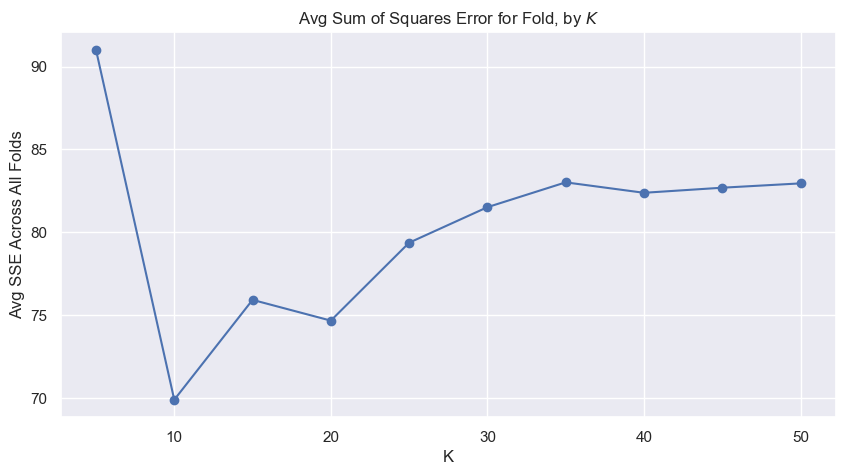

In [12]:
avg_sse.plot(figsize=(10,5),marker='o')
plt.title('Avg Sum of Squares Error for Fold, by $K$')
plt.xlabel('K')
plt.ylabel('Avg SSE Across All Folds')

In [13]:
best_k = int(avg_sse.sort_values().index[0])
print(f'The best lambda = {best_k}')

The best lambda = 10


In [14]:
best_results = pd.DataFrame(columns=['SSE','MSE','R_Squared'])

In [15]:
# Create and fit the model with the best K
# Create a Gurobi model
model = gp.Model()

# variables
beta = model.addMVar(X_train.shape[1] + 1, name="beta", lb=-np.inf)
z = model.addMVar(X_train.shape[1], vtype=GRB.BINARY, name="z")

# Objective function
residuals = gp.quicksum((y_train[j] - (beta[0] + gp.quicksum(beta[i + 1] * X_train[j, i] for i in range(X_train.shape[1]))))*(y_train[j] - (beta[0] + gp.quicksum(beta[i + 1] * X_train[j, i] for i in range(X_train.shape[1])))) for j in range(X_train.shape[0]))
model.setObjective(residuals, GRB.MINIMIZE)

# Add constraints
M = 100 # Set a large value for M
M2 = -M

bigMconspos = model.addConstrs((beta[i+1] <= M*z[i]) for i in range(50))
bigMconsneg = model.addConstrs((beta[i+1] >= M2*z[i]) for i in range(50))

z_con = model.addConstr(gp.quicksum(z[j] for j in range(X_train.shape[1])) == best_k)

# Optimize the model
model.Params.OutputFlag = 0
model.Params.TimeLimit = grb_runtime
model.optimize()

best_betas = beta.x

best_betas

array([ 0.97252408,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.30820726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51832612, -0.20416201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.55914318,  0.86697336,
        0.        , -1.31191942,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4081653 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.78147489,  0.        ,  0.88738292, -0.28229213,  0.        ,
        0.        ])

In [16]:

# Predict on hold out set and put the metrics into the best results df
gurobi_predictions = predictions(X_test,best_betas)

gurobi_sse = sse(y_test,gurobi_predictions)
gurobi_mse = mean_squared_error(y_test,gurobi_predictions)
gurobi_r_squared = r2_score(y_test,gurobi_predictions)

best_results.loc['Gurobi_Method_Metrics'] = [gurobi_sse,gurobi_mse,gurobi_r_squared]
best_results

,SSE,MSE,R_Squared
Gurobi_Method_Metrics,116.827198,2.336544,0.858668


## Lasso Regression

In [17]:
lasso_model_cv = linear_model.LassoCV(cv=10).fit(X_train_og,y_train_og)
best_lambda = lasso_model_cv.alpha_
print(f'The best lambda = {best_lambda}')

The best lambda = 0.07638765995113514


In [22]:
# Create and fit the best lasso.
best_lasso_model = Lasso(best_lambda).fit(X_train_og, y_train_og)

# Predict on hold out set and put the metrics into the best results df

# We can ignore that column of 1s that was added earlier for the lasso model
lasso_predictions = best_lasso_model.predict(X_test)
lasso_sse = sse(y_test,lasso_predictions)
lasso_mse = mean_squared_error(y_test,lasso_predictions)
lasso_r_squared = r2_score(y_test,lasso_predictions)

best_results.loc['Lasso_Metrics'] = [lasso_sse, lasso_mse, lasso_r_squared]

In [23]:
best_results

,SSE,MSE,R_Squared
Gurobi_Method_Metrics,116.827198,2.336544,0.858668
Lasso_Metrics,117.481738,2.349635,0.857876
